In [1]:
import sys
sys.path.append("../src/")

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
%matplotlib inline

In [4]:
import data_loader as dl
from draw import DRAW
from numpy_filterbank import filterbank

Using TensorFlow backend.


In [5]:
x_full, x_labeled, y = dl.load_simulated("128")
#(x_full, _), (x_labeled, y) = tf.keras.datasets.mnist.load_data()
y = y if len(y.shape) == 1 else y.argmax(1)
#x_full = np.expand_dims(x_full, -1)/ 255
#x_labeled = np.expand_dims(x_labeled, -1)/ 255

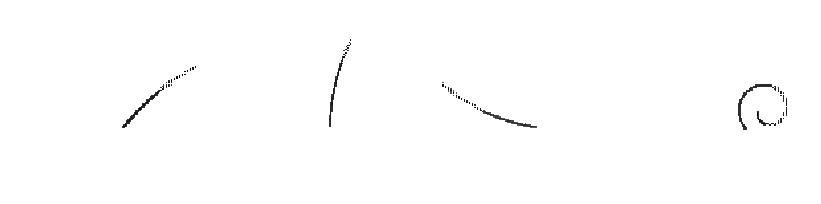

In [6]:
"""
The data comes in the form of images, we'll display a couple for clarity
"""
%matplotlib inline
fig, axs = plt.subplots(ncols=4, figsize=(14, 5))
og_events = [x_full[i].reshape(x_full[i].shape[0], x_full[i].shape[1]) for i in range(4)]
[axs[i].imshow(og_events[i], cmap="Greys") for i in range(4)]
[axs[i].axis("off") for i in range(4)]
plt.show()

(1, 20, 128)


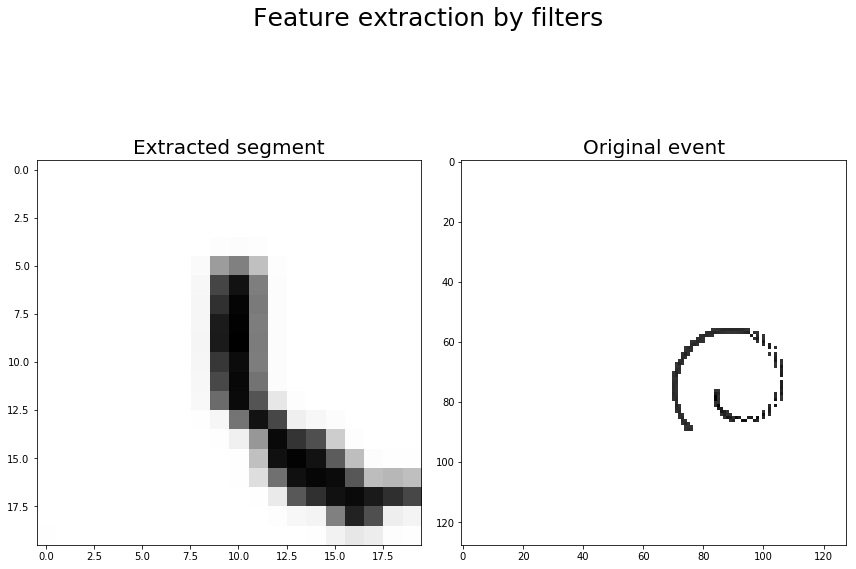

In [7]:
"""
The attention parameter delta and the number of filters N 
determines the amount of data seen at each time-step.
"""
ref_event = og_events[3]
gx = 85
gy = 80
sigma = 0.2
delta = 0.8
gamma = 1
N = 20
fb = filterbank(*x_full.shape[1:-1])
Fx, Fy = fb.filters(gx, gy, sigma, delta, gamma, N)
filtered = np.einsum("ijk, kl, lm->jm", Fy, ref_event, np.squeeze(np.transpose(Fx, [0, 2, 1])))

fig, ax = plt.subplots(ncols=2, figsize=(12, 10))
fig.suptitle("Feature extraction by filters", fontsize=25)
ax[0].imshow(np.squeeze(filtered), cmap="Greys")
ax[0].set_title("Extracted segment", fontsize=20)

ax[1].imshow(ref_event,  cmap="Greys")
ax[1].set_title("Original event", fontsize=20)
plt.tight_layout()

In [8]:
T = 3
enc_size = 400
dec_size = 100
latent_dim = 2

delta = 0.8
N = 20

delta_write = delta
delta_read = delta

read_N = N
write_N = N

attn_config = {
    "read_N": read_N,
    "write_N": write_N,
    "write_N_sq": write_N ** 2,
    "delta_w": delta_write,
    "delta_r": delta_read,
}

mode_config = {
    "simulated_mode":False, #deprecated, to be removed
    "restore_mode":False, #indicates whether to load weights 
    "include_KL":False, #whether to compute the KL loss over the latent space
    "include_MMD":True, #same as above, but MMD 
    "include_KM":False, #same as above, but K-means. See thesis for a more in-depth treatment of these
    "batchnorm":False, #whether to include batch-normalization between layers
    "use_vgg":False, #whether the input data is from a pre-trained model 
    "use_dd":False, #whether to use the dueling-decoder objective 
}

model = DRAW(
    T,
    dec_size,
    enc_size,
    latent_dim,
    x_full,
    beta=10,
    attn_config=attn_config,
    mode_config=mode_config
)

In [9]:
graph_kwds = {
    "activation": "lrelu",
    "output_activation": "sigmoid",
    "kernel_reg_strength": 1e-5,
}
loss_kwds = {
    "reconst_loss": None
}
model.compile_model(graph_kwds, loss_kwds)

In [10]:
optimizer = tf.train.AdamOptimizer
opt_args = [1e-3, ] #learning rate
opt_kwargs = {"beta1": 0.8, "beta2":0.99}
model.compute_gradients(optimizer, opt_args, opt_kwargs)

In [11]:
epochs = 200
batch_size = 100
earlystop = True
sess = tf.InteractiveSession()

lx, lz = model.train(
    sess,
    epochs,
    batch_size,
    earlystopping=earlystop
)

RUN NR 0
Removed: ../loss_records/tensorboard/run_0/events.out.tfevents.1567160390.ml3


ResourceExhaustedError: OOM when allocating tensor with shape[100,16384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node write/w/Adam_1/Assign (defined at ../src/model.py:871)  = Assign[T=DT_FLOAT, _class=["loc:@write/w"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](write/w/Adam_1, write/w/Adam_1/Initializer/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'write/w/Adam_1/Assign', defined at:
  File "/opt/conda/envs/python3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/python3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/envs/python3.6/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/opt/conda/envs/python3.6/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/opt/conda/envs/python3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3215, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-dec2e1e32bee>", line 4, in <module>
    model.compute_gradients(optimizer, opt_args, opt_kwargs)
  File "../src/model.py", line 871, in compute_gradients
    self.train_op = optimizer.apply_gradients(grads)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 593, in apply_gradients
    self._create_slots(var_list)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 136, in _create_slots
    self._zeros_slot(v, "v", self._name)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 1139, in _zeros_slot
    new_slot_variable = slot_creator.create_zeros_slot(var, op_name)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 183, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 157, in create_slot_with_initializer
    dtype)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 65, in _create_slot_var
    validate_shape=validate_shape)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 540, in get_variable
    aggregation=aggregation)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1481, in _init_from_args
    validate_shape=validate_shape).op
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 221, in assign
    validate_shape=validate_shape)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/opt/conda/envs/python3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,16384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node write/w/Adam_1/Assign (defined at ../src/model.py:871)  = Assign[T=DT_FLOAT, _class=["loc:@write/w"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](write/w/Adam_1, write/w/Adam_1/Initializer/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
"""
To explore the model status we can run intermediate aspects of interest of the graph
First, we confirm that the reconstructions are sane.
"""
sample = x_full[:4].reshape((4, -1))
feed_dict = {model.x:sample}
reconstructions = np.array(model.sess.run(model.canvas_seq, feed_dict))
print(reconstructions.shape)
reconstructions = reconstructions.reshape((T, 4,x_full.shape[1], x_full.shape[2]))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=T+1, figsize=(14, 25))

for t in range(T):
    canvasses = reconstructions[t]
    [a.imshow(canvas, cmap="Greys") for a, canvas in zip(ax[t], canvasses)]
    [ax[t][i].axis("off")for i in range(4)]

[a.imshow(og_event, cmap="Greys") for a, og_event in zip(ax[-1], og_events)]
tmp = [ax[-1][i].axis("off")for i in range(4)]

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
lx_run = lx[lx>0][2:]
lz_run = lz[lz>0][2:]
ax2 = ax.twinx()
l1 = ax.plot(np.arange(len(lx_run)), lx_run, label="Reconstruction", lw=2)
l2 = ax2.plot(np.arange(len(lx_run)), lz_run, c="orange", label="Latent", lw=2)
labels = l1+l2
ax.legend(labels, [l.get_label() for l in labels])
ax.set_xlabel("Epoch")
ax.set_ylabel(r"$L_x$")
ax2.set_ylabel(r"$L_z$")
ax.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
ax2.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))

In [ ]:
"""
Secondly we want to inspect the latent space to investigate if we can visually 
identify a clustering. We chose the latent dimension to be 2 to give an easy 
visualization. We observe that there is a very good class separation in the space.
"""
all_labeled = x_labeled.reshape((x_labeled.shape[0], -1))
latent_labeled = np.array(model.run_large(sess, model.z_seq, all_labeled))
#latent_labeled = TSNE(2).fit_transform(latent_labeled)
fig, ax = plt.subplots(figsize=(10, 14), ncols=2, nrows=T)
physics = ["Proton", "Carbon"]
mnist = ["{}".format(i) for i in range(len(np.unique(y)))]
classes = physics if len(np.unique(y)) == 2 else mnist


for t in range(T):
    for i in range(len(np.unique(y))):
        ax[t][1].scatter(latent_labeled[t][:,0], latent_labeled[t][:,1], alpha=0.3, c="b")
        class_samples = latent_labeled[t][y == i]
        ax[t][0].scatter(class_samples[:,0], class_samples[:,1], label=classes[i], alpha=0.4)
        if t == 0:
            ax[t][i].set_title("Latent space of simulated AT-TPC data")
        ax[t][i].set_aspect("equal")
        ax[t][0].legend(loc="best")

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 14), ncols=2)
physics = ["Proton", "Carbon"]
mnist = ["{}".format(i) for i in range(len(np.unique(y)))]
classes = physics if len(np.unique(y)) == 2 else mnist
print(latent_labeled.shape, np.repeat(np.expand_dims(y == 0, 0), T, 0).shape)
#print(latent_labeled.shape)
lines = ax[1].plot(latent_labeled[:, :200, 0], latent_labeled[:, :200, 1], "-x", c="b")
colors = ["g", "b"]

for i in range(len(np.unique(y))):
    lines = ax[0].plot(latent_labeled[:, y==i, 0], latent_labeled[:, y==i, 1], "-x", c=colors[i], alpha=0.1)